In [1]:
%cd ..

D:\anomaly-detection


In [2]:
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline(connected=True)

from bokeh.io import output_notebook
output_notebook()

from ipywidgets import interact, fixed

import statsmodels.tsa.api as sm
import statsmodels.tsa.stattools as ts

from src.features.build_features import rolling_window
from src.models.DDRE import *

Loading BokehJS ...

In [3]:
maxlags = 10

In [4]:
def make_stationary_1d(data):
    if isinstance(data, pd.Series):
        data = data.values
    while ts.adfuller(data, maxlags)[1] > 0.01:
        data = data[1:] - data[:-1]
    return data
    
def make_stationary_2d(data):
    min_len = data.shape[0]
    for component in range(data.shape[1]):
        print(f'Component {component}')
        stat = make_stationary_1d(data.iloc[:, component])
        l = stat.shape[0]
        data.iloc[:min(data.shape[0], l), component] = stat
        min_len = min(l, min_len)
    return data.iloc[:min_len]

In [5]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [6]:
data = make_stationary_2d(data)

Component 0
Component 1
Component 2
Component 3
Component 4
Component 5
Component 6
Component 7
Component 8
Component 9
Component 10
Component 11
Component 12
Component 13
Component 14
Component 15
Component 16
Component 17
Component 18
Component 19
Component 20
Component 21
Component 22
Component 23
Component 24
Component 25
Component 26
Component 27
Component 28
Component 29
Component 30
Component 31
Component 32
Component 33
Component 34
Component 35
Component 36
Component 37
Component 38
Component 39
Component 40


In [7]:
first_half, second_half = data.iloc[:data.shape[0]//2], data.iloc[data.shape[0]//2:]

In [8]:
@interact(data=fixed(data), component=(0, second_half.shape[1]-1))
def plot_component(data, component):
    data = data.iloc[:, component].values
    dif = 0
    while ts.adfuller(data, 10)[1] > 0.05:
        data = data[1:] - data[:-1]
        dif += 1
    pprint(ts.adfuller(data, 10))
    print(dif)
    plt.plot(data)

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

In [127]:
# too slow
# var = sm.VARMAX(first_half.values[:300], order=(1, 1))

# res = var.fit(maxiter=100, callback=lambda x: print(x))

KeyboardInterrupt: 

In [9]:
var = sm.VAR(first_half)

res = var.fit(maxlags=100)

In [10]:
forecast = res.forecast(first_half.values, second_half.shape[0])

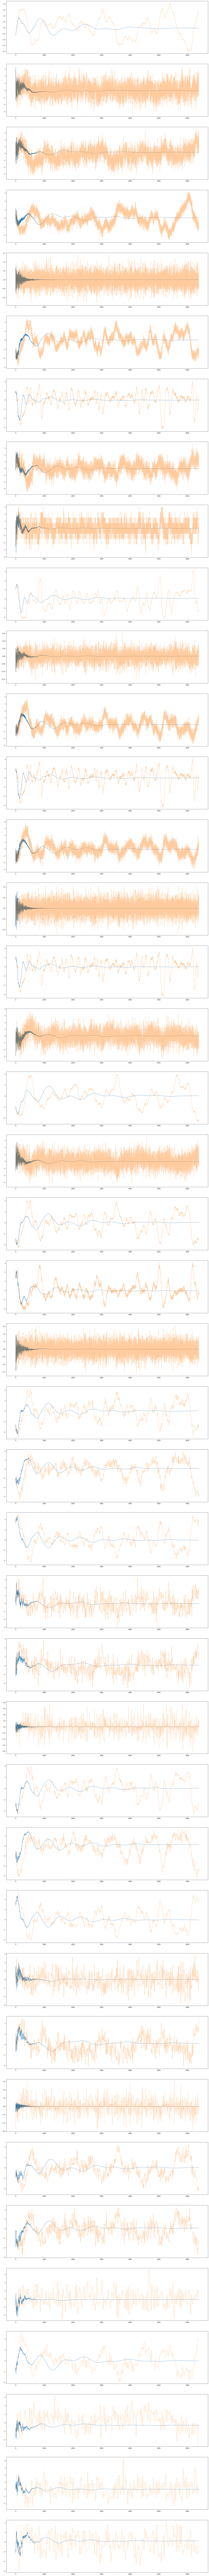

In [11]:
plt.figure(figsize=(25, 8*second_half.shape[1]))
for i in range(second_half.shape[1]):
    plt.subplot(second_half.shape[1], 1, i+1)
    plt.plot(forecast[:, i], linestyle='--')
    plt.plot(second_half.values[:, i], alpha=0.4)